# 1 - Kalbe Product Sales Prediction

Tujuan dari proyek ini adalah untuk melakukan prediksi terhadap penjualan produk dalam 14 hari ke depan dengan membandingkan dua algoritma forecasting, yaitu Exponential Smoothing Holt's winter dan Autoregressive Integrated Moving Average (ARIMA) dengan auto-ARIMA.

Setelah dilakukan analisis, model yang paling akurat adalah yaitu Auto-ARIMA dan digunakan pada Proses Forecasting

# 2 - Introduction

Nama : Dicky Librata Sembiring 

Batch : FTDS-003

Dataset : kalbe_data.xlsx

Objective : Memprediksi penjualan setiap produk dan kategori untuk 14 hari mendatang

# 3 - External Link
Model Deployment
- Hugging Face : https://huggingface.co/spaces/barentz96/Sales_Forecasting

# 4 - Working Area

## Import Library

Berikut adalah library yang digunakan pada project ini

In [1]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

import pickle

import warnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

## Data Loading

Selanjutnya dilakukan loading dataset. Kemudian beberapa eksplorasi sederhana seperti melihat jumlah baris dan kolom data, nama dan type data masing - masing kolom, serta basic info dari data yang telah di load

Dari sumber dataset, penulis memperoleh informasi mengenai masing - masing column sebagai berikut:
- day : hari penjualan produk
- category : kategori dari produk. Terdapat 2 kategori yaitu A dan B
- product : nama produk. Terdiri dari 4 produk. A1, A2, B1, dan B2
- sales : jumlah produk terjual di hari tersebut

Dataset terdiri dari beberapa sheet pada file excel. Sehingga proses load data akan menjadi 4 dataframe

In [2]:
# load dataset
a1 = pd.read_excel('kalbe_data.xlsx', sheet_name='A1')
a2 = pd.read_excel('kalbe_data.xlsx', sheet_name='A2')
b1 = pd.read_excel('kalbe_data.xlsx', sheet_name='B1')
b2 = pd.read_excel('kalbe_data.xlsx', sheet_name='B2')

In [3]:
# set display pandas
pd.options.display.float_format = '{:.2f}'.format

Ini adalah tampilan 5 data awal setiap sheet

In [4]:
# tampilkan 5 data awal
a1.head()

,Day,Category,Product,Sales
0,1,A,A1,100.00
1,2,A,A1,101.00
2,3,A,A1,102.01
3,4,A,A1,103.03
4,5,A,A1,104.06


In [5]:
# tampilkan 5 data awal
a2.head()

,Day,Category,Product,Sales
0,1,A,A2,1000.00
1,2,A,A2,1005.00
2,3,A,A2,1010.02
3,4,A,A2,1015.08
4,5,A,A2,1020.15


In [6]:
# tampilkan 5 data awal
b1.head()

,Day,Category,Product,Sales,Event
0,1,B,B1,990.00,0
1,2,B,B1,980.00,0
2,3,B,B1,1010.00,0
3,4,B,B1,1010.00,0
4,5,B,B1,1000.00,0


In [7]:
# tampilkan 5 data awal
b2.head()

,Day,Category,Product,Sales
0,1,B,B2,NaN
1,2,B,B2,NaN
2,3,B,B2,NaN
3,4,B,B2,NaN
4,5,B,B2,NaN


In [8]:
# Jumlah baris dan kolom A1
print('-'*5, ' Sheet A1 ', '-'*5)
print(f"Jumlah baris Sheet A1 : {a1.shape[0]}")
print(f"Jumlah kolom Sheet A1 : {a1.shape[1]}\n")

# Jumlah baris dan kolom A2
print('-'*5, ' Sheet A2 ', '-'*5)
print(f"Jumlah baris Sheet A1 : {a2.shape[0]}")
print(f"Jumlah kolom Sheet A1 : {a2.shape[1]}\n")

# Jumlah baris dan kolom B1
print('-'*5, ' Sheet B1 ', '-'*5)
print(f"Jumlah baris Sheet A1 : {b1.shape[0]}")
print(f"Jumlah kolom Sheet A1 : {b1.shape[1]}\n")

# Jumlah baris dan kolom B2
print('-'*5, ' Sheet B2 ', '-'*5)
print(f"Jumlah baris Sheet A1 : {b2.shape[0]}")
print(f"Jumlah kolom Sheet A1 : {b2.shape[1]}\n")

-----  Sheet A1  -----
Jumlah baris Sheet A1 : 90
Jumlah kolom Sheet A1 : 4

-----  Sheet A2  -----
Jumlah baris Sheet A1 : 90
Jumlah kolom Sheet A1 : 4

-----  Sheet B1  -----
Jumlah baris Sheet A1 : 104
Jumlah kolom Sheet A1 : 5

-----  Sheet B2  -----
Jumlah baris Sheet A1 : 104
Jumlah kolom Sheet A1 : 4



Secara sheet A1 dan A2 memiliki `90 baris` dan `4 kolom`, 

Sedangkan sheet B1 memiliki `104 baris` dan `5 Kolom` dan B2 memiliki `104 baris` dan `4 Kolom`

## Exploratory Data Analysis (EDA)

### Cek Missing Value
Hal pertama yang dilakukan adalag memastikan bahwa data yang akan digunakan sudah layak untuk digunakan dengan melakukan pengecekan missing value

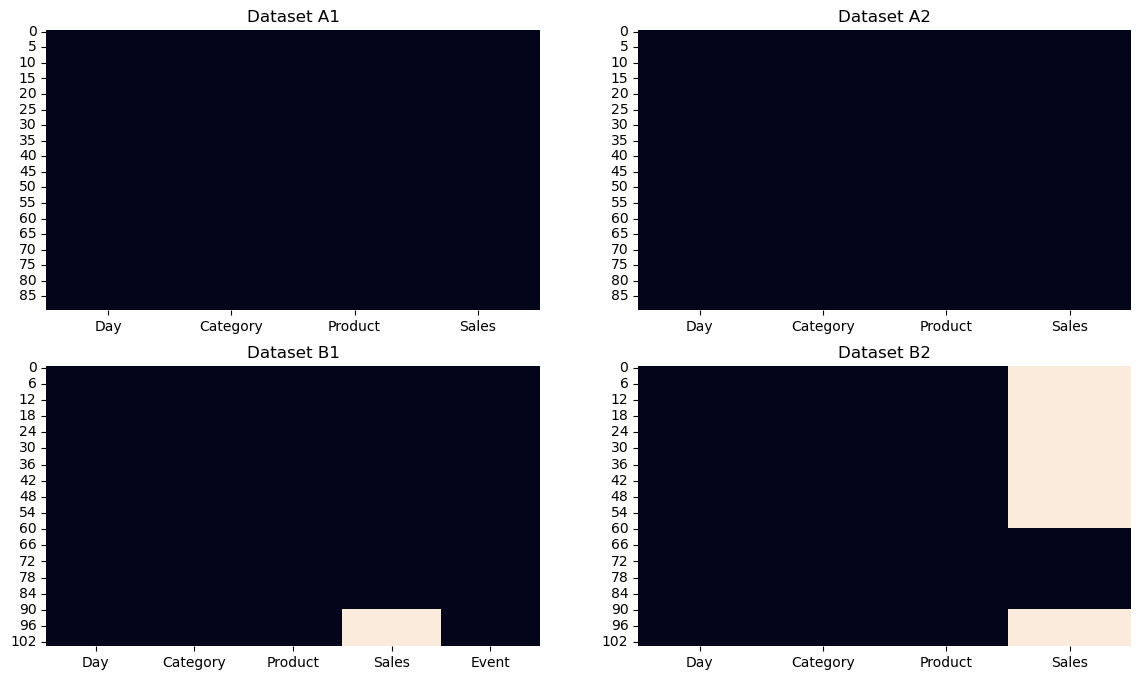

In [9]:
# counter untuk subplot
count = 221
# counter untuk title
title_count = 0
# loist title
title = ['A1', 'A2', 'B1', 'B2']
# figure 14 x 8
plt.figure(figsize=[14,8])
# looping untuk melihat missing value
for x in [a1,a2,b1,b2]:
    plt.subplot(count)
    sns.heatmap(x.isnull(), cbar=False)
    plt.title(f'Dataset {title[title_count]}')
    count += 1
    title_count += 1
plt.show()

Dari hasil pengecekan diatas diperoleh informasi berikut :
- Tidak ditemukan `missing value` pada dataset a1 dan a2
- Namun terdapat missing value pada dataset b1 dan b2

Karena project ini merupakan forecasting dengan menggunakan data historis dari sales sehingga tidak boleh ada missing value.

Missing value pada dataset B1 dan B2 tidak bercampur (selang - seling) dengan data. Sehingga akan dilakukan droping / trimming pada data yang ada missing value

In [10]:
# copy b1
b1_ori = b1.copy()

In [11]:
# drop missing value pada b1 dan b2
b1 = b1.dropna()
b2 = b2.dropna()

Selanjutnya dilakukan penngecekan kembali untuk memastikan tidak ada lagi data yang missing

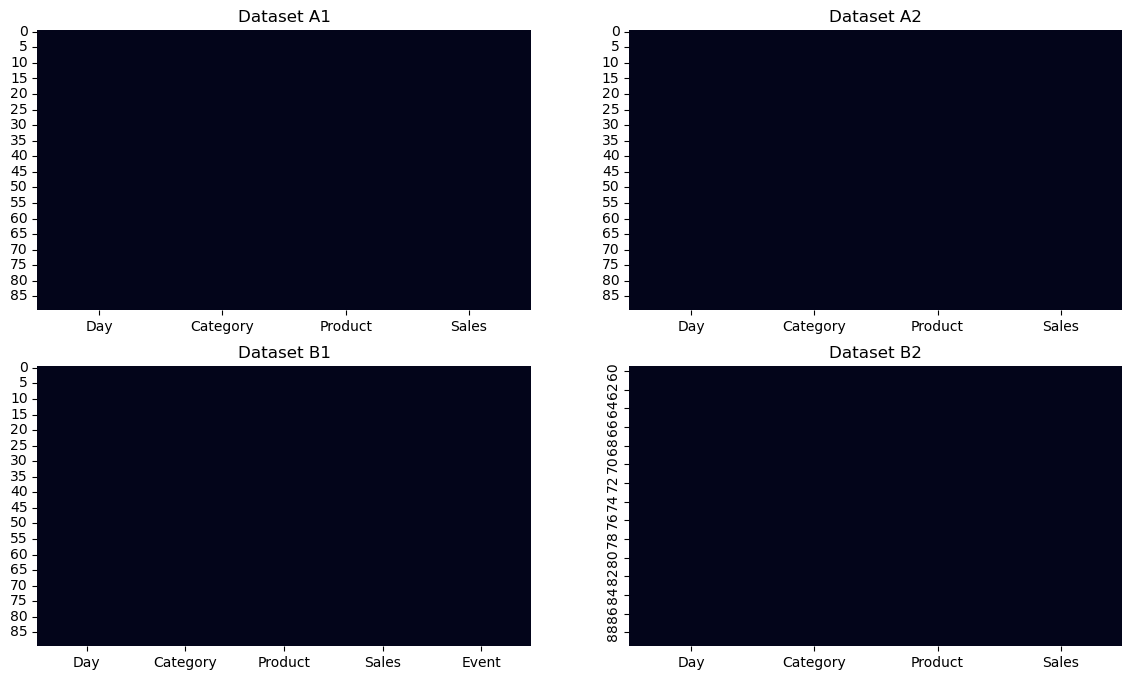

In [12]:
# counter untuk subplot
count = 221
# counter untuk title
title_count = 0
# loist title
title = ['A1', 'A2', 'B1', 'B2']
# figure 14 x 8
plt.figure(figsize=[14,8])
# looping untuk melihat missing value
for x in [a1,a2,b1,b2]:
    plt.subplot(count)
    sns.heatmap(x.isnull(), cbar=False)
    plt.title(f'Dataset {title[title_count]}')
    count += 1
    title_count += 1
plt.show()

Dari informasi pada data loading, informasi waktu masih berbentuk `integer`. Sehingga perlu dilakuan proses convert menjadi bentuk `tanggal`. Karena ini hanya sebagai permisalan, penulis mengambil tanggal `01 Januari 2022` sebagai awal dan akan mengenerate tanggal berikutnya sesuai jumlah data `tanpa` memperhitungkan `business day`

In [13]:
# Mengubah Day angka menjadi format tanggal dengan freq harian
a1.Day = pd.date_range(start='1/1/2022', periods=len(a1), freq='D')
a2.Day = pd.date_range(start='1/1/2022', periods=len(a2), freq='D')
b1.Day = pd.date_range(start='1/1/2022', periods=len(b1), freq='D')
b2.Day = pd.date_range(start='1/1/2022', periods=len(b2), freq='D')

### Membuat series untuk setiap dataset
Selanjutnya adalah membuat dataset dengan menggunakan kolom sales dan day yang sudah diubah menjadi tanggal

In [14]:
# membuat data time series
a1 = a1.set_index('Day')
a1_data = a1['Sales']

a2 = a2.set_index('Day')
a2_data = a2['Sales']

b1 = b1.set_index('Day')
b1_data = b1['Sales']

b2 = b2.set_index('Day')
b2_data = b2['Sales']

Berikut sebagai contoh series dari dataset b2

In [15]:
# tampilkan 5 data pertama
b2_data.head()

Day
2022-01-01    10.00
2022-01-02    20.00
2022-01-03    40.00
2022-01-04    80.00
2022-01-05   144.00
Name: Sales, dtype: float64

### Descriptive Analysis
Pada tahap ini, penulis mencari insigth yang dapat diperoleh berdasarkan informasi dari data series yang telah di buat

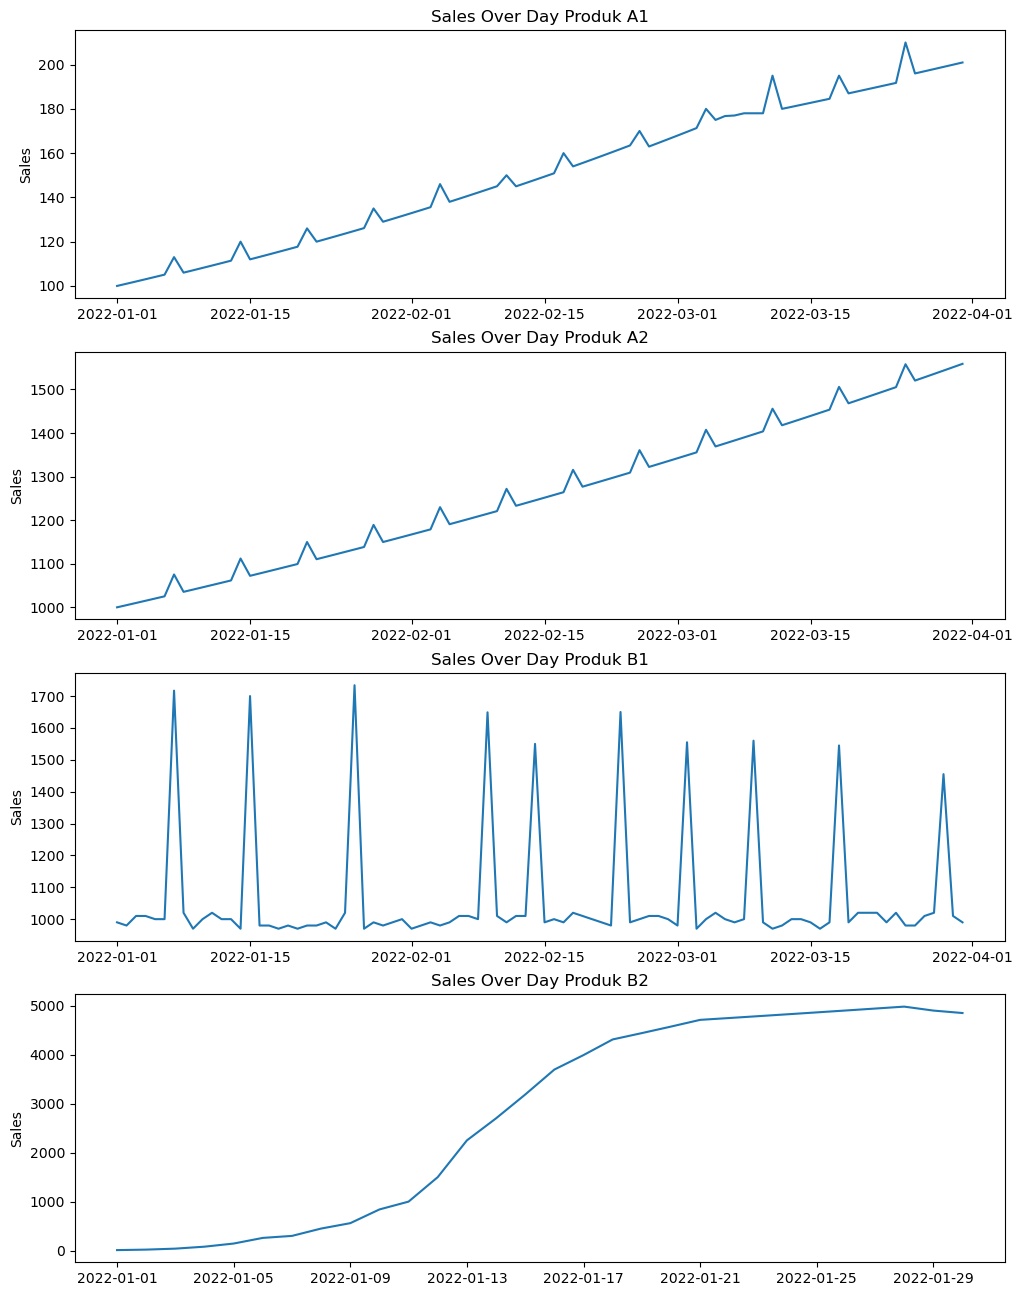

In [16]:
# counter untuk subplot
count = 411
# counter untuk title
title_count = 0
# loist title
title = ['A1', 'A2', 'B1', 'B2']
# figure 14 x 8
plt.figure(figsize=[12,16])
# looping untuk melihat missing value
for x in [a1_data, a2_data, b1_data, b2_data]:
    plt.subplot(count)
    sns.lineplot(data=x)      # lineplot with seaborn
    plt.title(f'Sales Over Day Produk {title[title_count]}')     # set title
    plt.xlabel('')
    count += 1
    title_count += 1
plt.show()

Dari hasil visualisasi linechart diatas, diperoleh informasi sebagai berikut :
- Dataset A1 :
    - Terdapat `trend kenaikan` dari hari awal hingga akhir
    - Namun ada `spike` yang relatif sama besar dari awal hingga akhir. Artinya terdapat `seasonalitas` yang bersifat `additive` pada dataset
    - Ada sedikit `perbedaan` pada awal minggu pertama Maret yaitu sedikit `fluktuatif` dibandingkan minggu lainnya 
- Dataset A2 :
    - Terdapat `trend kenaikan` dari hari awal hingga akhir
    - Namun ada `spike` yang relatif sama besar dari awal hingga akhir. Artinya terdapat `seasonalitas` yang bersifat `additive` pada dataset
- Dataset B1 :
    - Terdapat `trend penurunan` dari hari awal hingga akhir
    - Namun ada `spike` yang mengecil dari awal hingga akhir. Artinya terdapat `seasonalitas` yang bersifat `damped`
- Dataset B2 :
    - Terdapat `trend kenaikan` dari hari awal hingga pertengahan namun cenderung stagnan hingga akhir
    - Tidak ada spike sehingga dapat disimpulkan tidak ada seasonalitas

### Series Decomposition
Untuk memperoleh informasi lebih lanjut, penulis melakukan `dekomposisi` pada data dengan menggunakan library `statsmodels`

#### Produk A1

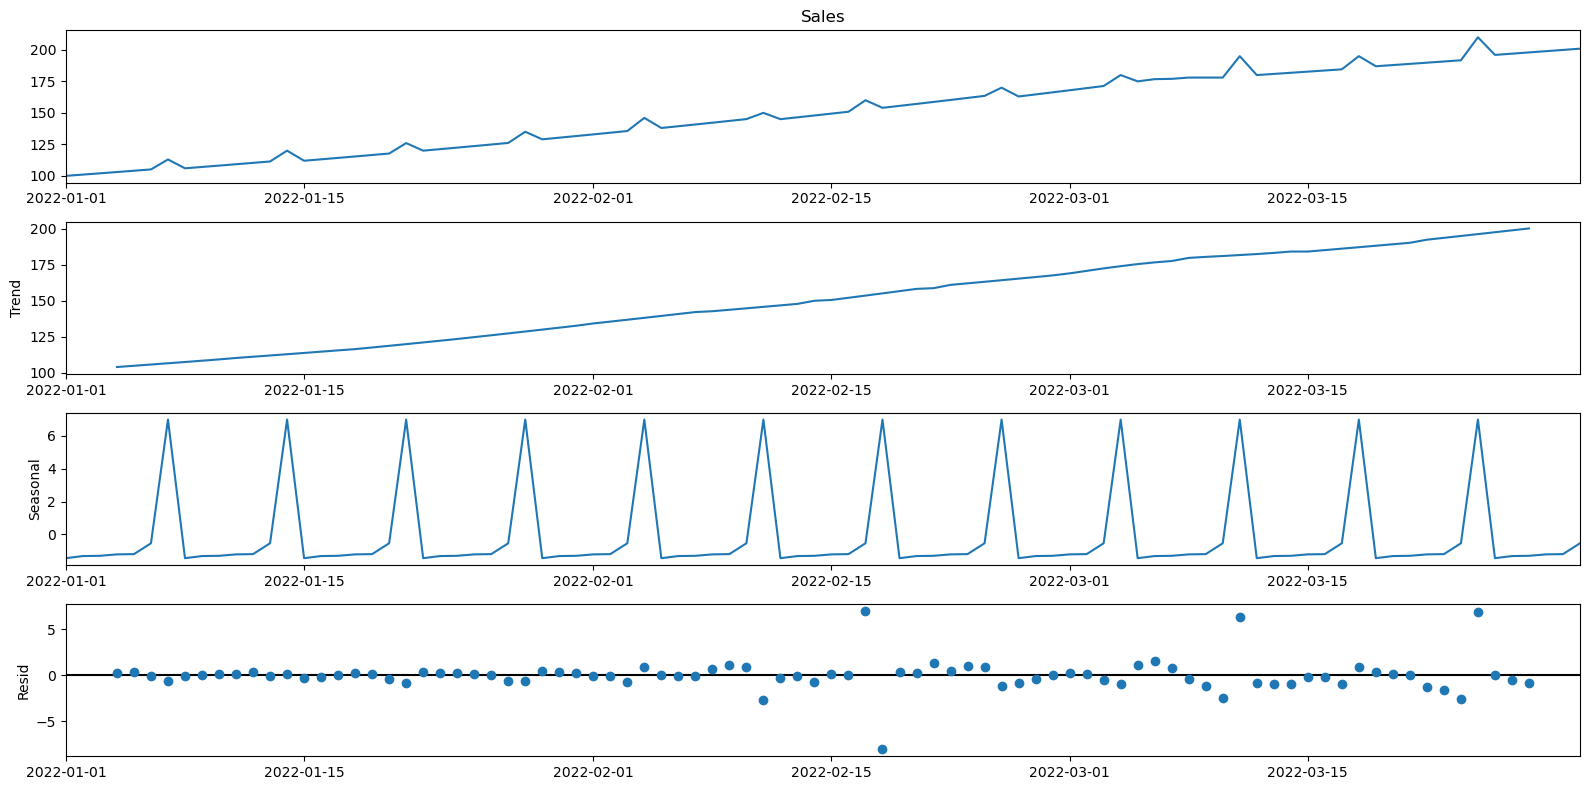

In [17]:
# dekomposisi dataset A1
decomposed = seasonal_decompose(a1_data, model='add')      # seasonal additive
fig = decomposed.plot()     # plot hasil dekomposisi
fig.set_size_inches((16, 8))    # atur ukuran visualisasi
fig.tight_layout()
plt.show()

Dari hasil plot diatas, lebih terlihat jelas bahwa terdapat trend dan seasonalitas pada dataset.
- Trend bermula pada jumlah sales sekitar `100` dan berakhir pada jumlah sales sekitar `200`
- Terdapat season pada dataset set dengan range `7 hari`

#### Produk A2

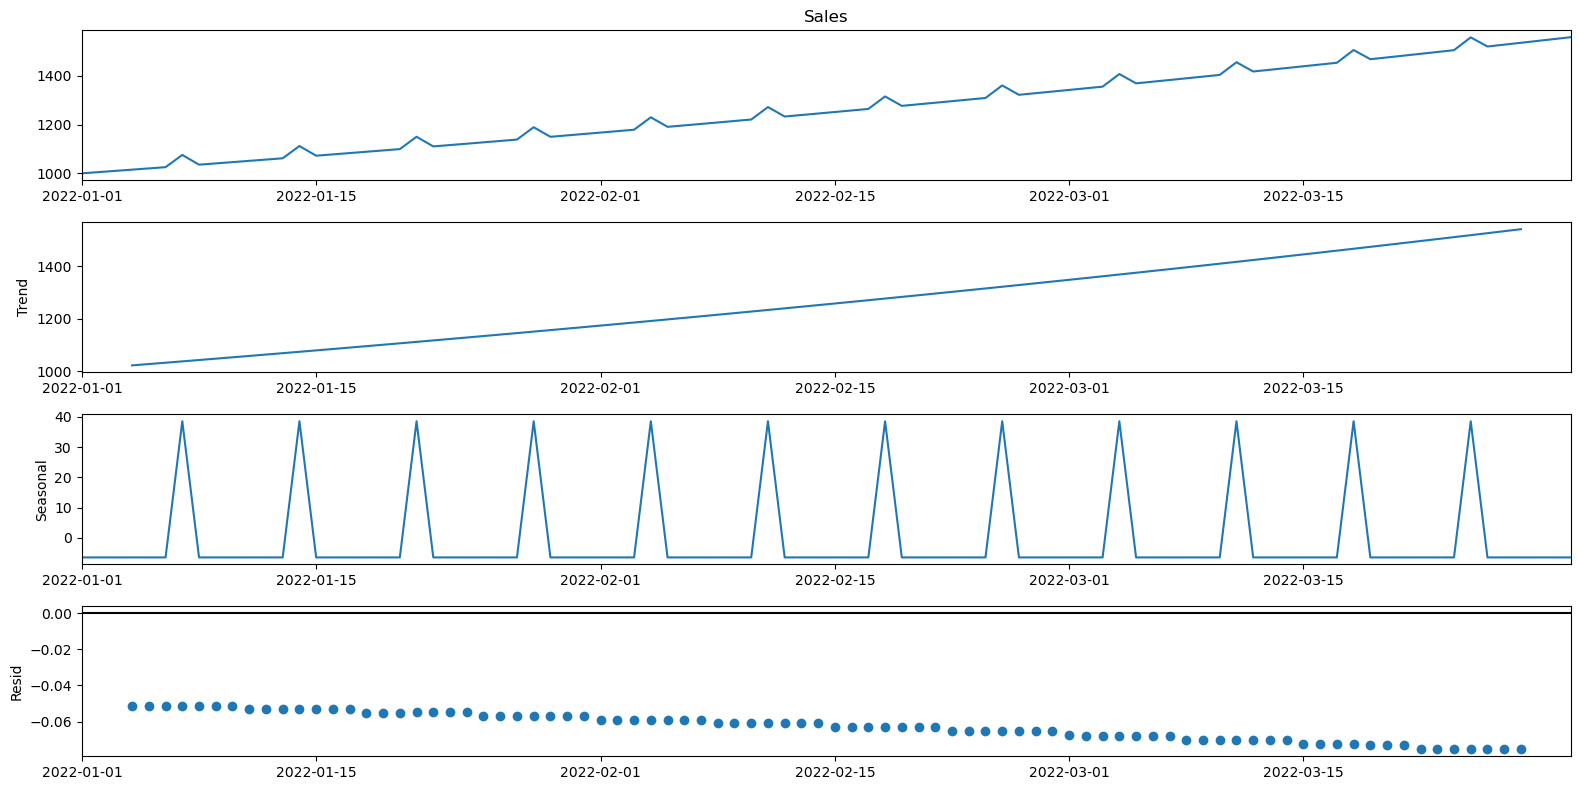

In [18]:
# dekomposisi dataset A2
decomposed = seasonal_decompose(a2_data, model='add')      # seasonal additive
fig = decomposed.plot()     # plot hasil dekomposisi
fig.set_size_inches((16, 8))    # atur ukuran visualisasi
fig.tight_layout()
plt.show()

Dari hasil plot diatas, lebih terlihat jelas bahwa terdapat trend dan seasonalitas pada dataset.
- Trend bermula dengan jumlah sales sekitar `1000` dan berakhir dengan sales sekitar `1500`
- Terdapat season pada dataset set dengan range `7 hari`

#### Produk B1

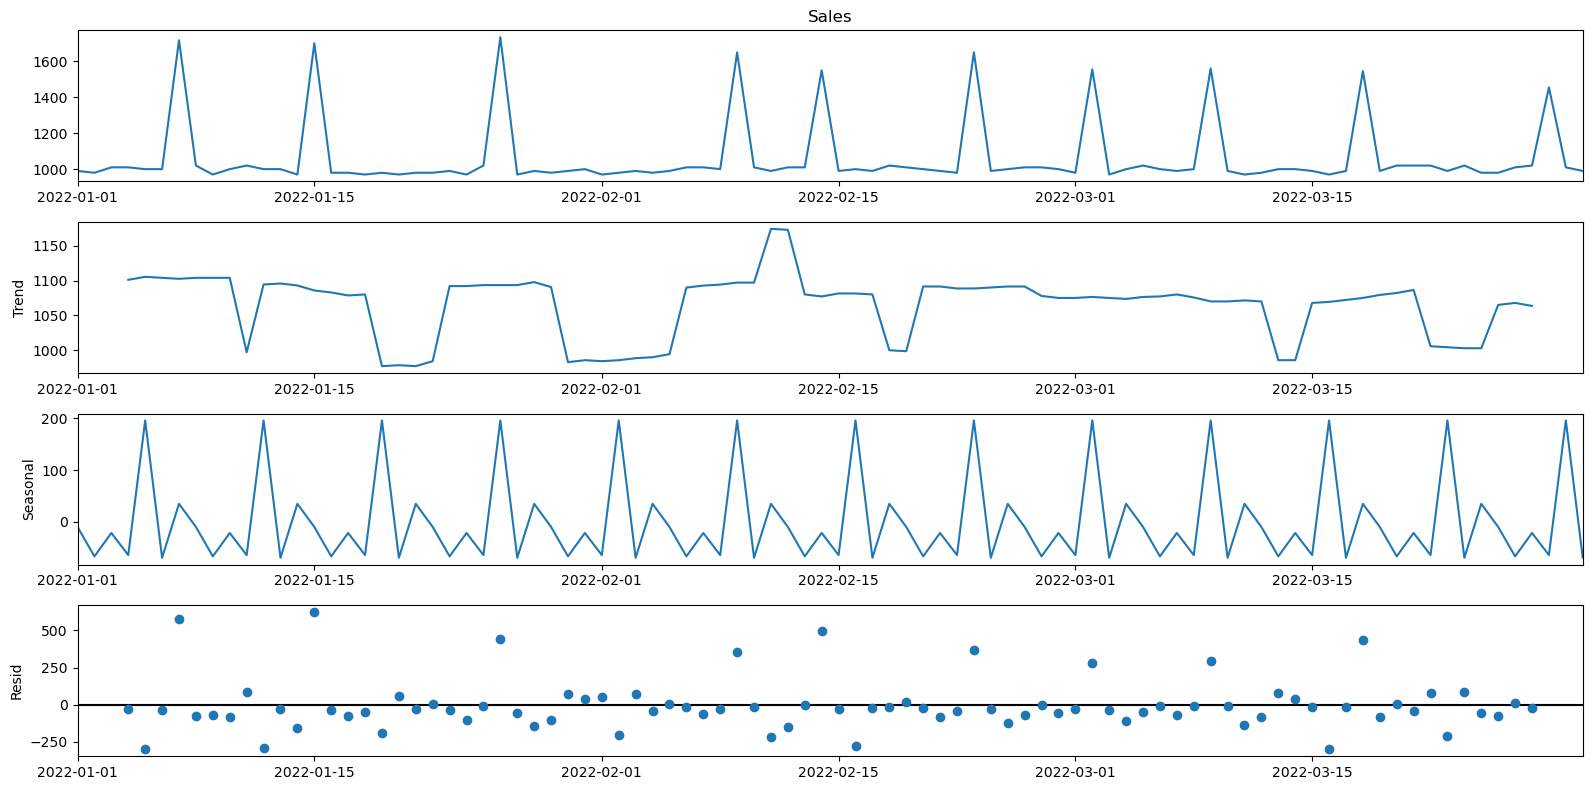

In [19]:
# dekomposisi dataset A2
decomposed = seasonal_decompose(b1_data, model='add')      # seasonal additive
fig = decomposed.plot()     # plot hasil dekomposisi
fig.set_size_inches((16, 8))    # atur ukuran visualisasi
fig.tight_layout()
plt.show()

Dari hasil plot diatas, lebih terlihat bahwa tidak terdapat trend namun terdapat seasonalitas pada dataset.
- Sales dari waktu kewaktu flukatif pada range `950` sampai `1100`
- Terdapat season pada dataset dengan range `6 hari`

#### Produk B2

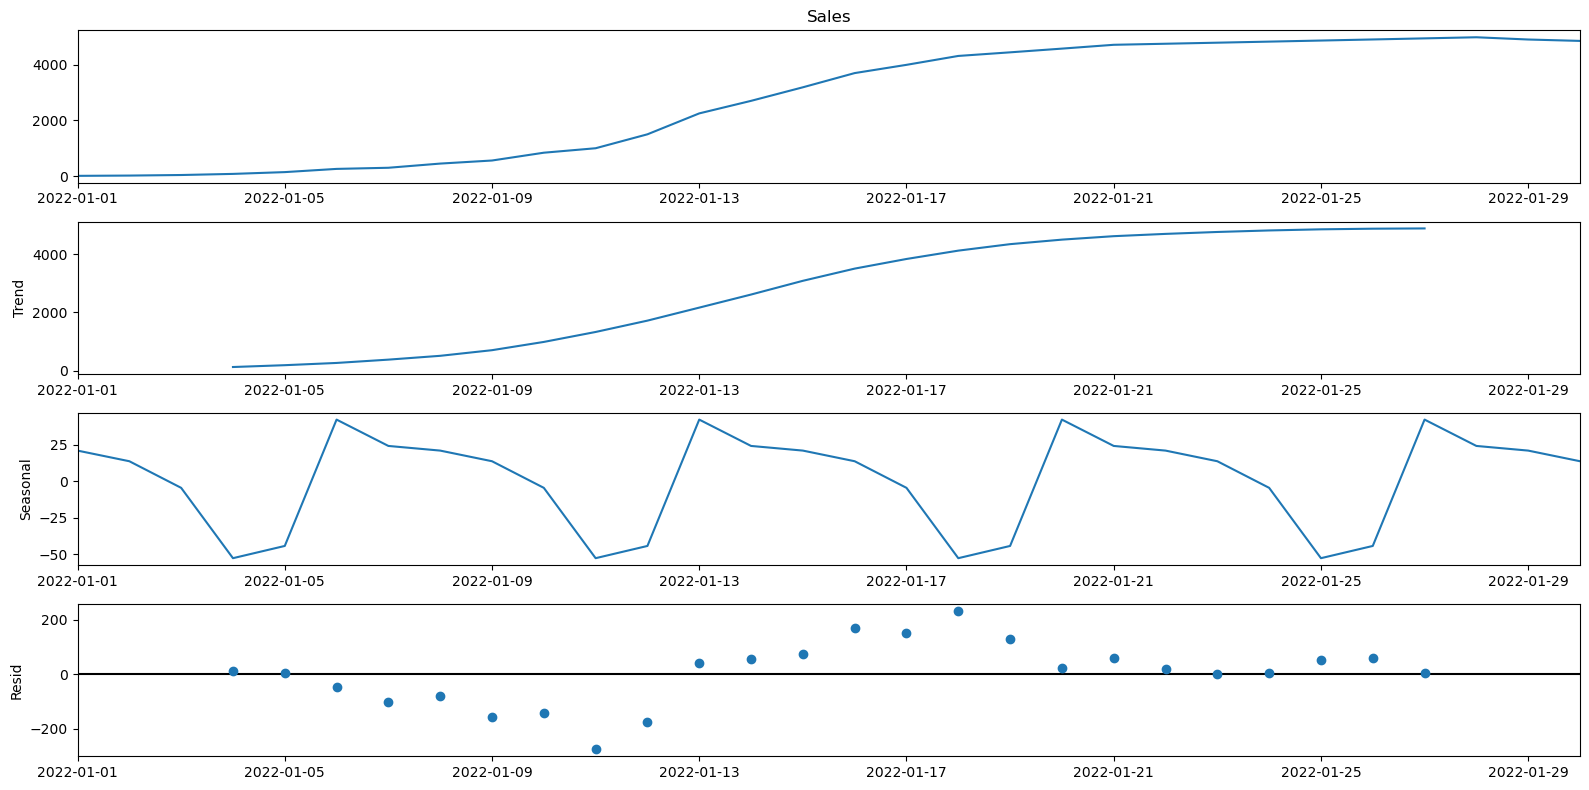

In [20]:
# dekomposisi dataset A2
decomposed = seasonal_decompose(b2_data, model='none')      # seasonal additive
fig = decomposed.plot()     # plot hasil dekomposisi
fig.set_size_inches((16, 8))    # atur ukuran visualisasi
fig.tight_layout()
plt.show()

Dari hasil plot diatas, lebih terlihat jelas bahwa terdapat trend dan seasonalitas pada dataset.
- Trend bermula dengan jumlah sales sekitar mulai dari mendekati `0` dan berakhir dengan sales sekitar `4000` Sales
- Terdapat season pada dataset dengan range `7 hari`

### Stationery Test
Selanjutnya adalah melakukan pengecekan stasionaritas setiap dataset dengan `Augmented Dickey Fuller (adfuller)` dari library `statsmodel`

In [21]:
# membuat fungsi adf checker 
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [22]:
# check nilai adfuller pada dataset A1
print(f'{adf_test(a1_data)}')

ADF Statistic: 0.160245
p-value: 0.969942
None


In [23]:
# check nilai adfuller pada dataset A2
print(f'{adf_test(a2_data)}')

ADF Statistic: 171433648791662.125000
p-value: 1.000000
None


In [24]:
# check nilai adfuller pada dataset B1
print(f'{adf_test(b1_data)}')

ADF Statistic: -6.194331
p-value: 0.000000
None


In [25]:
# check nilai adfuller pada dataset b2
print(f'{adf_test(b2_data)}')

ADF Statistic: -1.692955
p-value: 0.434746
None


Dengan level signifikansi 0.05 atau confidence level 95% dapat diperoleh informasi sebagai berikut :
- Dataset A1  dan A2 bersifat `tidak stasioner` karena nilai p-value 0.9699 dan 1.00 yang artinya lebih besar dari 0.005
- Dataset B1 bersifat `stasioner` karena nilai p-value 0.0000 dan lebih kecil dari level signifikansi 0.005
- Dataset B2 bersifat `tidak stasioner karena nilai p-value 0.4347 dan lebih besar dari level signifikansi 0.005

## Split Train Test


Setelah memperoleh informasi pada proses EDA, selanjutnya penulis mempersiapkan `data train dan data test` yang akan di pakai pada model training dan model evaluasi.

Karena dataset yang terbatas, maka penulis memutuskan untuk membagi data train dan data test dengan `perbandingan 1 : 5`
Pada dataset A1, A2, dan B1
- Data train : 75 Data
- Data test : 15 data

Sedangkan pada dataset B2
- Data train : 25 Data
- Data test : 5 data

#### Produk A1
Berikut adalah pembagian data train dan data test pada dataset A1

In [26]:
# splitting train and test dataset A1
a1_X_train=a1_data[:75] 
a1_X_test=a1_data[75:]

print(f"Train size : {a1_X_train.shape}")
print(f"Test size : {a1_X_test.shape}")

Train size : (75,)
Test size : (15,)


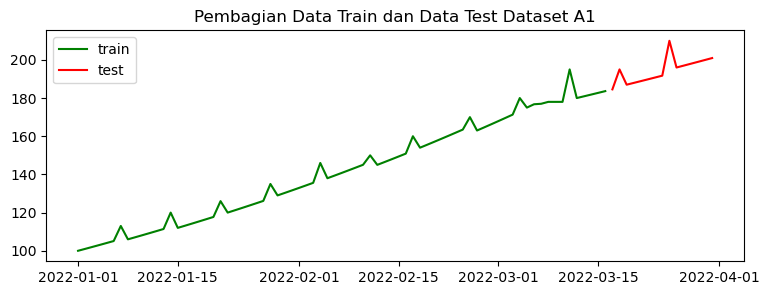

In [27]:
# membuat sebuah figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(a1_X_train, 'g-', label='train')  # data train
plt.plot(a1_X_test, 'r-', label='test')    # data test
plt.title('Pembagian Data Train dan Data Test Dataset A1')
plt.legend()
plt.show()

#### Produk A2
Berikut adalah pembagian data train dan data test pada dataset A2

In [28]:
# splitting train and test dataset A2
a2_X_train=a2_data[:75] 
a2_X_test=a2_data[75:]

print(f"Train size : {a2_X_train.shape}")
print(f"Test size : {a2_X_test.shape}")

Train size : (75,)
Test size : (15,)


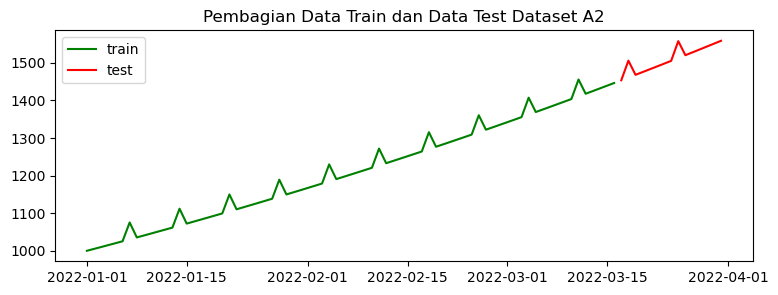

In [29]:
# membuat sebuah figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(a2_X_train, 'g-', label='train')  # data train
plt.plot(a2_X_test, 'r-', label='test')    # data test
plt.title('Pembagian Data Train dan Data Test Dataset A2')
plt.legend()
plt.show()

#### ProdukB1
Berikut adalah pembagian data train dan data test pada dataset B1

In [30]:
# splitting train and test dataset B1
b1_X_train=b1_data[:75] 
b1_X_test=b1_data[75:]

print(f"Train size : {b1_X_train.shape}")
print(f"Test size : {b1_X_test.shape}")

Train size : (75,)
Test size : (15,)


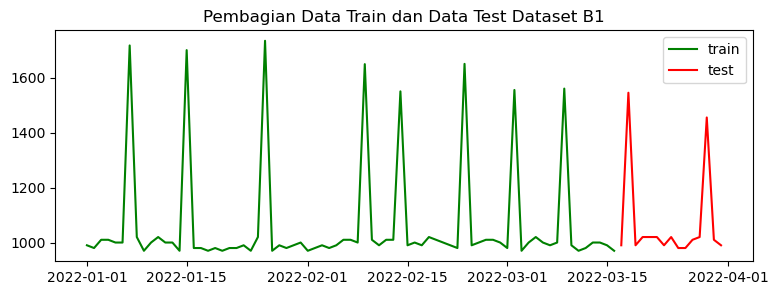

In [31]:
# membuat sebuah figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(b1_X_train, 'g-', label='train')  # data train
plt.plot(b1_X_test, 'r-', label='test')    # data test
plt.title('Pembagian Data Train dan Data Test Dataset B1')
plt.legend()
plt.show()

#### Produk B2
Berikut adalah pembagian data train dan data test pada dataset B2

In [32]:
# splitting train and test dataset B2
b2_X_train=b2_data[:22] 
b2_X_test=b2_data[22:]

print(f"Train size : {b2_X_train.shape}")
print(f"Test size : {b2_X_test.shape}")

Train size : (22,)
Test size : (8,)


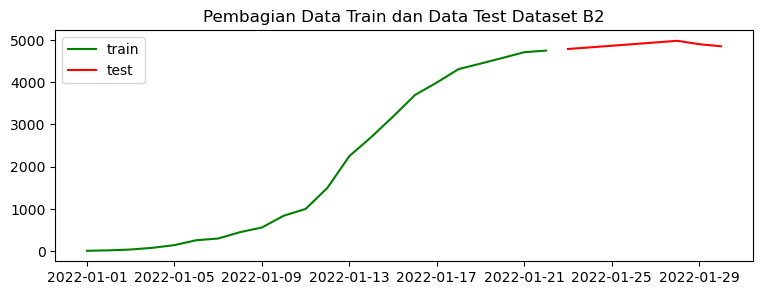

In [33]:
# membuat sebuah figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(b2_X_train, 'g-', label='train')  # data train
plt.plot(b2_X_test, 'r-', label='test')    # data test
plt.title('Pembagian Data Train dan Data Test Dataset B2')
plt.legend()
plt.show()

## Model Definition dan Model Traning

Dengan informasi yang diperoleh sebelumnya, penulis memutuskan untuk menggunakan model `Exponential Smoothing Holts Winters`
Parameter yang digunakan adalah :
- Produk A1
    - Trend = additive
    - Seasonalitas = multiplicative
- Produk A2
    - Trend = additive
    - Seasonalitas = multiplicative
- Produk B1
    - Trend = None
    - Seasonalitas = additive
- Produk B2
    - Trend = multiplicative
    - Seasonalitas = multiplicative

In [34]:
# define model and training holts winter pada data train A1
a1_es = ExponentialSmoothing(a1_X_train, trend='add', seasonal='mul', damped_trend=True)
a1_model_es = a1_es.fit(optimized=True, damping_trend=0.999)

# define model and training holts winter pada data train A2
a2_es = ExponentialSmoothing(a2_X_train, trend='add', seasonal='mul')
a2_model_es = a2_es.fit(optimized=True)

# define model and training holts winter pada data train B1
b1_es = ExponentialSmoothing(b1_X_train, seasonal='add')
b1_model_es = b1_es.fit(optimized=True)

# define model and training holts winter pada data train B2
b2_es = ExponentialSmoothing(b2_X_train, trend='add', seasonal='mul', damped_trend=True, seasonal_periods=7)
b2_model_es = b2_es.fit(optimized=True, damping_trend=0.5)

## Model Evaluation
Setelah membuat dan melakukan training model, penulis melakukan prediksi pada data test. Evaluasi akan dilakukan dengan membandingkan prediksi dengan data test sebenarnya.

Beberapa cara membandingkan adalah :
- Visualisasi
- Metric Evaluasi :
    - `Mean Absolute Error ( MEA )` : Digunakan untuk mengukur besaran eror dari prediksi model terhadap nilai sebenarnya dari target
    - `R2 Scrore` : Digunakan untuk melihat bagaimana performa model dalam mengikuti pola dari data yang tersedia
    - `Mean Absolute Percentage Error (MAPE)` : Mengitung persentase besar eror nilai prediksi terhadap nilai aktual

### Produk A1

In [35]:
# prediksi model dataset A1
a1_pred_es = a1_model_es.predict(a1_X_test.index[0], a1_X_test.index[-1])

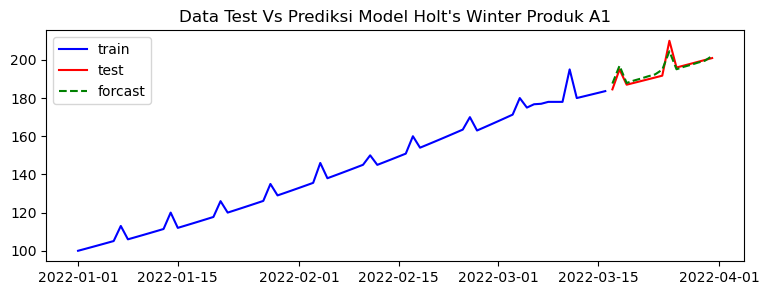

In [36]:
# membuat figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(a1_X_train, 'b-', label='train')        # plot data train
plt.plot(a1_X_test, 'r-', label='test')          # plot data test
plt.plot(a1_pred_es, 'g--', label='forcast')     # plot prediksi
plt.title("Data Test Vs Prediksi Model Holt's Winter Produk A1")
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` menumpuk dengan plot `data test`. Artinya model berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [37]:
# print judul
print('-'*15, ' TEST EVALUATION A1', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(a1_X_test,a1_pred_es):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(a1_X_test,a1_pred_es)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(a1_X_test,a1_pred_es):.4f}")

---------------  TEST EVALUATION A1 ---------------
Mean Absolute Error (MAE) : 1.6188
Mean Absolute Percentage Error (MAPE) : 0.8290%
R2 Score : 0.8952


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `1.618`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales yang berkisar ratusan. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `0.8290%`. Persentase ini membuktikan bahwa nilai eror 1.618 sudah cukup kecil.

Sedangkan Nilai R2 Score menunjukkan bagaimana model mengikuti pola dari dataset yang dipelajari. Range nilai R2 Score adalah antara minus tak hingga sampai dengan 1 dan 1 merupakan saat model berhasil secara sempurna mengikuti pola. Nilai R2 Score pada data train `0.895` berarti model berhasil mengikuti pola data sebesar 89%

#### Produk A2

In [38]:
# prediksi model dataset A2
a2_pred_es = a2_model_es.predict(a2_X_test.index[0], a2_X_test.index[-1])

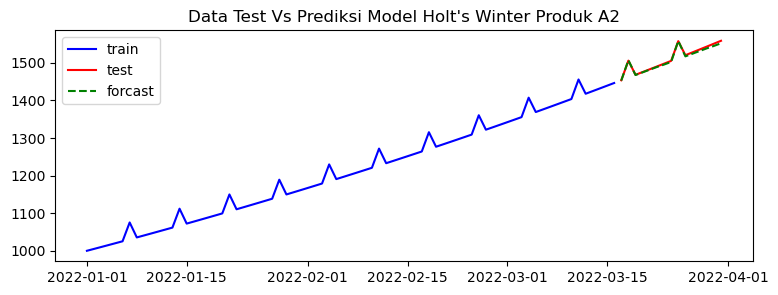

In [39]:
# membuat figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(a2_X_train, 'b-', label='train')        # plot data train
plt.plot(a2_X_test, 'r-', label='test')          # plot data test
plt.plot(a2_pred_es, 'g--', label='forcast')     # plot prediksi
plt.title("Data Test Vs Prediksi Model Holt's Winter Produk A2")
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` menumpuk dengan plot `data test`. Artinya model berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [40]:
# print judul
print('-'*15, ' TEST EVALUATION A2', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(a2_X_test,a2_pred_es):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(a2_X_test,a2_pred_es)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(a2_X_test,a2_pred_es):.4f}")

---------------  TEST EVALUATION A2 ---------------
Mean Absolute Error (MAE) : 2.6139
Mean Absolute Percentage Error (MAPE) : 0.1710%
R2 Score : 0.9900


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `2.6139`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales yang berkisar ribuan. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `0.1710%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `0.99` berarti model berhasil mengikuti pola data sebesar 99%

#### Produk B1

In [41]:
# prediksi model dataset B1
b1_pred_es = b1_model_es.predict(b1_X_test.index[0], b1_X_test.index[-1])

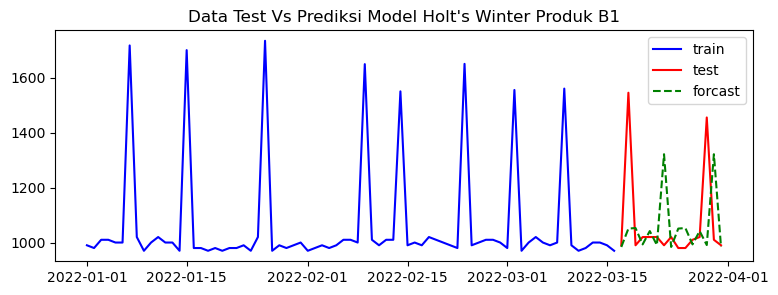

In [42]:
# membuat figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(b1_X_train, 'b-', label='train')        # plot data train
plt.plot(b1_X_test, 'r-', label='test')          # plot data test
plt.plot(b1_pred_es, 'g--', label='forcast')     # plot prediksi
plt.title("Data Test Vs Prediksi Model Holt's Winter Produk B1")
plt.legend()
plt.show()

Dari hasil visualisasi diatas, hasil plot dari `prediksi` tidak menumpuk dengan plot `data test`. Artinya model kurang baik memprediksi pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [43]:
# print judul
print('-'*15, ' TEST EVALUATION B1', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(b1_X_test,b1_pred_es):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(b1_X_test,b1_pred_es)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(b1_X_test,b1_pred_es):.4f}")

---------------  TEST EVALUATION B1 ---------------
Mean Absolute Error (MAE) : 131.4427
Mean Absolute Percentage Error (MAPE) : 11.0218%
R2 Score : -0.5730


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `133.4427`. Nilai ini merupakan nilai yang cukup besar . Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `11.0218%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `-0.5730` berarti model gagal mengikuti pola datanya

#### Produk B2

In [44]:
# prediksi model dataset B2
b2_pred_es = b2_model_es.predict(b2_X_test.index[0], b2_X_test.index[-1])

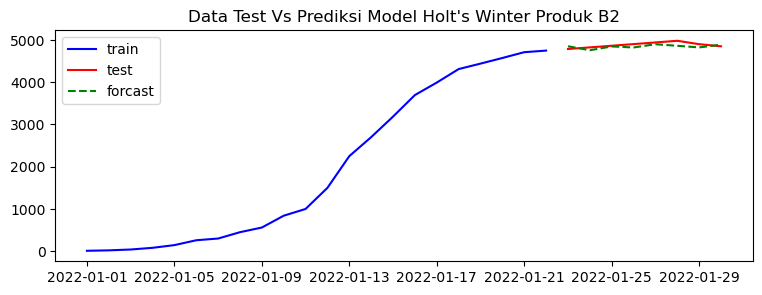

In [45]:
# membuat figure 12 x 4
plt.figure(figsize=[9,3])
plt.plot(b2_X_train, 'b-', label='train')        # plot data train
plt.plot(b2_X_test, 'r-', label='test')          # plot data test
plt.plot(b2_pred_es, 'g--', label='forcast')     # plot prediksi
plt.title("Data Test Vs Prediksi Model Holt's Winter Produk B2")
plt.legend()
plt.show()

Dari hasil visualisasi diatas, hasil plot dari `prediksi` terlihat cukup `menumpuk` dengan plot `data test`. Artinya model cukup baik memprediksi pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [46]:
# print judul
print('-'*15, ' TEST EVALUATION B2', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(b2_X_test,b2_pred_es):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(b2_X_test,b2_pred_es)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(b2_X_test,b2_pred_es):.4f}")

---------------  TEST EVALUATION B2 ---------------
Mean Absolute Error (MAE) : 63.0451
Mean Absolute Percentage Error (MAPE) : 1.2887%
R2 Score : -0.3849


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `63.0451`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales yang berkisar `4000`. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `1.2887%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `-0.3849` berarti model tidak berhasil mengikuti pola. 

Nilai error cukup kecil namun model tidak berhasil mengikuti pola datanya

## Model Comparation

Dengan menggunakan model exponential smoothing holt's winters diperoleh hasil yang cukup baik.

Namun penulis juga mencoba menggunakan model Autoregressive Integrated Moving Average (ARIMA) namun untuk menentukan parameternya menggunakan stepwise search.

Hal ini dapat dilakukan dengan menggunakan `auto_arima` dari library `pmdarima`. Namun khusus untuk Produk `B1` dikarenakan data memiliki kolom `event` maka dilakukan dengan ARIMA secara manual

### Model Definition dan Model Training
Dari proses EDA penulis memperoleh informasi bahwa beberapa dataset memiliki seasonal dengan periode 7 hari. Informasi ini dijadikan acuan untuk auto arima mencari parameter yang terbaik. 

Seperti metode search lainnya, auto arima memerlukan parameter untuk mencari membandingkan antar combinasi. Pada model ini penulis mengunakan `Akaike Information Criterion with correction (AICc)`. AICc merupakan modifikasi dari AIC untuk dataset yang relative kecil sesuai dengan dataset projek ini. AIC digunakan untuk mengukur seberapa baik suatu model cocok dengan data dan seberapa sederhana model tersebut. Semakin kecil nilai AIC, semakin baik model tersebut. 

#### Produk A1

In [47]:
# define dan training model
a1_model_arima  = auto_arima(a1_X_train ,seasonal=True, m=7, information_criterion='aicc',random_state=42)

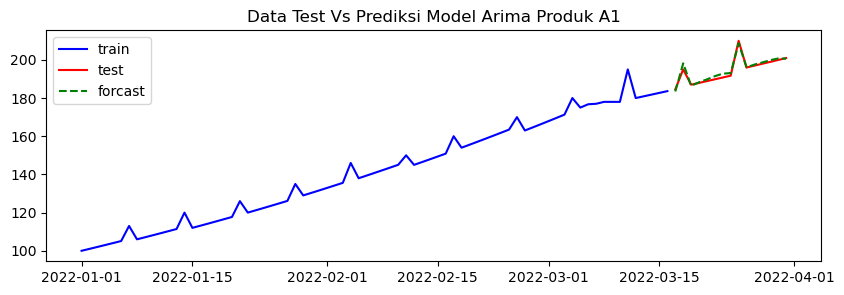

In [48]:
# define range forcast
range_forcast = len(a1_X_test)
# predict data
a1_pred_arima = a1_model_arima.predict(range_forcast)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(a1_X_test.index[0], periods=range_forcast, freq='D')
a1_pred_arima = pd.Series(a1_pred_arima, index=dates)

# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(a1_X_train, 'b-', label='train')        # plot data train
plt.plot(a1_X_test, 'r-', label='test')          # plot data test
plt.plot(a1_pred_arima, 'g--', label='forcast')     # plot prediksi
plt.title('Data Test Vs Prediksi Model Arima Produk A1')
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` menumpuk dengan plot `data test`. Artinya model berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [49]:
# print judul
print('-'*15, ' TEST EVALUATION B1', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(a1_X_test,a1_pred_arima):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(a1_X_test,a1_pred_arima)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(a1_X_test,a1_pred_arima):.4f}")

---------------  TEST EVALUATION B1 ---------------
Mean Absolute Error (MAE) : 1.0460
Mean Absolute Percentage Error (MAPE) : 0.5393%
R2 Score : 0.9598


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `1.0460`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `0.5393%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `0.9598` berarti model berhasil mengikuti pola data sebesar 95%

#### Produk A2

In [50]:
# define mode dan training
a2_model_arima  = auto_arima(a2_X_train, seasonal=True, m=7, information_criterion='aicc',random_state=42)

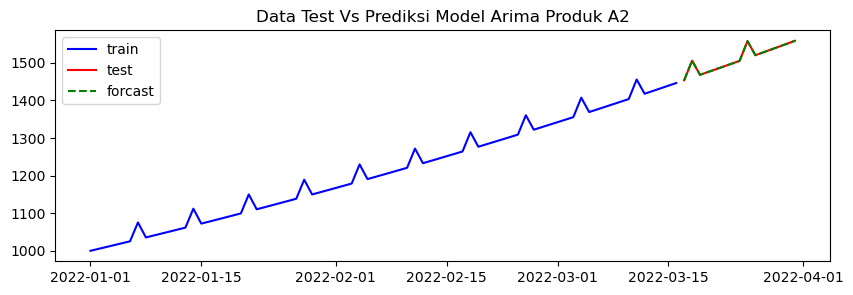

In [51]:
# define range forcast
range_forcast = len(a2_X_test)
# predict data
a2_pred_arima = a2_model_arima.predict(range_forcast)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(a2_X_test.index[0], periods=range_forcast, freq='D')
a2_pred_arima = pd.Series(a2_pred_arima, index=dates)

# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(a2_X_train, 'b-', label='train')        # plot data train
plt.plot(a2_X_test, 'r-', label='test')          # plot data test
plt.plot(a2_pred_arima, 'g--', label='forcast')     # plot prediksi
plt.title('Data Test Vs Prediksi Model Arima Produk A2')
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` `sangat menumpuk` dengan plot `data test`. Artinya model berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [52]:
# print judul
print('-'*15, ' TEST EVALUATION B1', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(a2_X_test,a2_pred_arima):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(a2_X_test,a2_pred_arima)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(a2_X_test,a2_pred_arima):.4f}")

---------------  TEST EVALUATION B1 ---------------
Mean Absolute Error (MAE) : 0.0110
Mean Absolute Percentage Error (MAPE) : 0.0007%
R2 Score : 1.0000


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `0.0110`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `0.0007%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `1.00` berarti model berhasil mengikuti pola data sebesar 100%

#### Produk B1
Seperti Informasi sebelumnya bahwa Produk B1 memiliki kolom event maka Model Arima dilakukan secara manual

Dengan menggunakan plot acf dan pacf dari library statsmodels, penulis menentukan order ARIMA

##### ACF

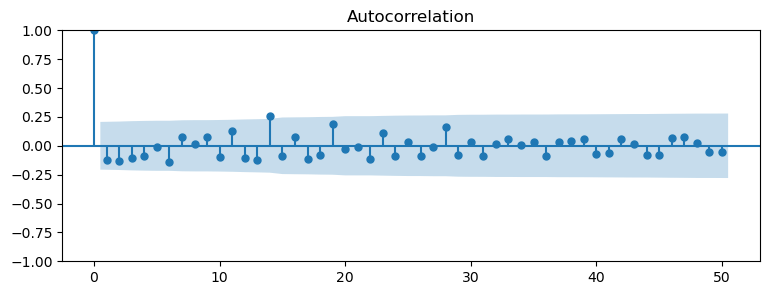

In [53]:
# figure 9 x 3
fig, ax = plt.subplots(figsize=(9, 3))
#plot acf
acf_plot = plot_acf(b1_data, lags=50,ax=ax)

##### PACF

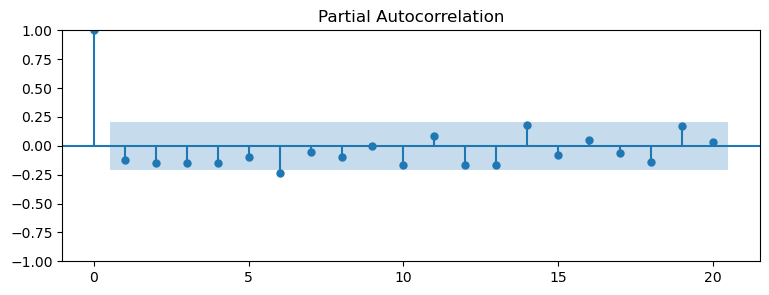

In [54]:
# figure 9 x 3
fig, ax = plt.subplots(figsize=(9, 3))
# ploy pacf
pacf_plot = plot_pacf(b1_data,ax=ax,method='ywm')

Dari hasil plot diatas, orde yang paling signifikan adalah 14. Maka orde dari :
- Auto Regresi : 6
- Inferencing : 0. Karena tidak ada proses differensiasi
- Moving Average : 14

In [55]:
# define model arima dengan kolom event
b1_model_arima = ARIMA(b1['Sales'], order=(6,0,14), exog=b1['Event'])
b1_model_arima = b1_model_arima.fit()

In [56]:
# predict
b1_pred_arima = b1_model_arima.predict(start=b1_X_test.index[0], end=b1_X_test.index[-1], exog=b1['Event'][75:])

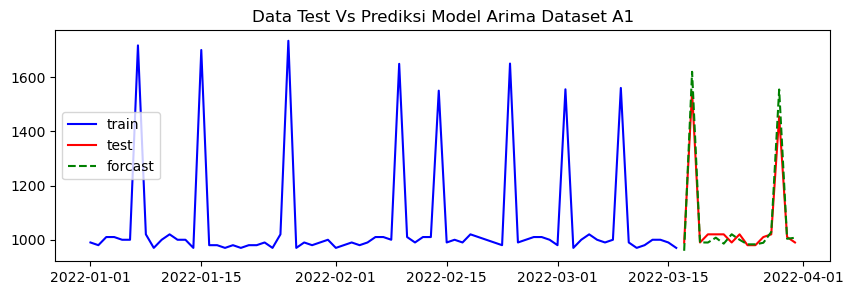

In [57]:
plt.figure(figsize=[10,3])
plt.plot(b1_X_train, 'b-', label='train')        # plot data train
plt.plot(b1_X_test, 'r-', label='test')          # plot data test
plt.plot(b1_pred_arima, 'g--', label='forcast')     # plot prediksi
plt.title('Data Test Vs Prediksi Model Arima Dataset A1')
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` `cukup menumpuk` dengan plot `data test`. Artinya model berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakna metrik evaluasi

In [58]:
# print judul
print('-'*15, ' TEST EVALUATION B1', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(b1_X_test,b1_pred_arima):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(b1_X_test,b1_pred_arima)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(b1_X_test,b1_pred_arima):.4f}")

---------------  TEST EVALUATION B1 ---------------
Mean Absolute Error (MAE) : 26.0703
Mean Absolute Percentage Error (MAPE) : 2.2152%
R2 Score : 0.9522


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `26.0703`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `2.2152%`

Sama dengan defenisi sebelumnya, Nilai R2 Score pada data train `0.95` berarti model berhasil mengikuti pola data sebesar 95%

#### Produk B2

In [59]:
# # define dan training model
b2_model_arima  = auto_arima(b2_X_train, seasonal=True, m=7, information_criterion='aicc',random_state=42)


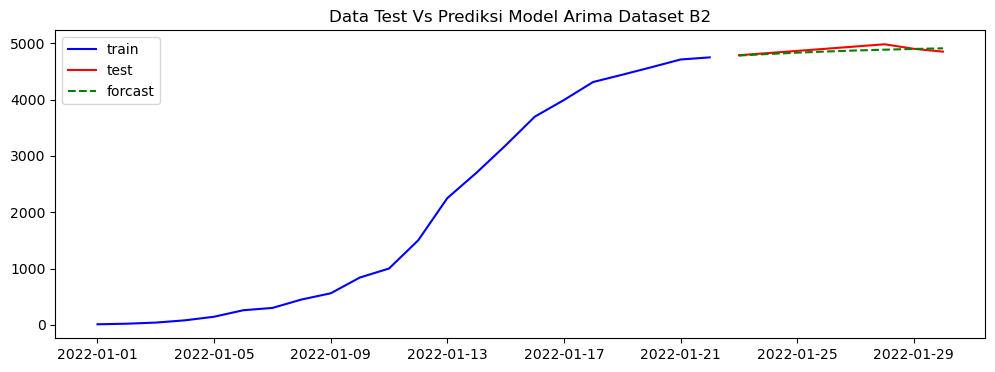

In [60]:
# define range forcast
range_forcast = len(b2_X_test)
# predict data
b2_pred_arima = b2_model_arima.predict(range_forcast)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(b2_X_test.index[0], periods=range_forcast, freq='D')
b2_pred_arima = pd.Series(b2_pred_arima, index=dates)

# membuat figure 12 x 4
plt.figure(figsize=[12,4])
plt.plot(b2_X_train, 'b-', label='train')        # plot data train
plt.plot(b2_X_test, 'r-', label='test')          # plot data test
plt.plot(b2_pred_arima, 'g--', label='forcast')     # plot prediksi
plt.title('Data Test Vs Prediksi Model Arima Dataset B2')
plt.legend()
plt.show()

Terlihat pada visualisasi model hasil plot dari `prediksi` cukup menumpuk dengan plot `data test`. Artinya model cukup berhasil memprediksi dengan cukup baik pada data test. Selanjutkan akan dibuktikan dengan menggunakan metrik evaluasi

In [61]:
# print judul
print('-'*15, ' TEST EVALUATION B2', '-'*15)
# mae
print(f"Mean Absolute Error (MAE) : {mean_absolute_error(b2_X_test,b2_pred_arima):.4f}")
# mape
print(f"Mean Absolute Percentage Error (MAPE) : {mean_absolute_percentage_error(b2_X_test,b2_pred_arima)*100:.4f}%")
# r2 score
print(f"R2 Score : {r2_score(b2_X_test,b2_pred_arima):.4f}")

---------------  TEST EVALUATION B2 ---------------
Mean Absolute Error (MAE) : 41.3164
Mean Absolute Percentage Error (MAPE) : 0.8408%
R2 Score : 0.2302


Rata rata nilai eror dari prediksi (MAE) terhadap data test adalah `41.31`. Nilai ini cukup kecil jika di bandingkan dengan range nilai sales sekutar `4000`. Untuk lebih spesifik dapat dilihat pada nilai MAPE. Persentase rata rata error adalah `0.8408%`

Namun untuk nilai R2 Score pada data test `0.23` berarti model hanya berhasil mengikuti pola data sebesar 23%

## Comparation Beetwen Holt's Model Vs Arima Model
Setelah melakukan evaluasi pada kedua model, penulis membandingkan hasil metrik evaluasi kedua model

### Produk A1

In [62]:
# mae
print('-'*5, " Mean Absolute Error (MAE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_error(a1_X_test,a1_pred_es):.4f}")
print(f"Arima : {mean_absolute_error(a1_X_test,a1_pred_arima):.4f}\n")

# mape
print('-'*5, " Mean Absolute Percentage Error (MAPE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_percentage_error(a1_X_test,a1_pred_es)*100:.4f}")
print(f"Arima : {mean_absolute_percentage_error(a1_X_test,a1_pred_arima)*100:.4f}\n")

# r2 score
print('-'*5, " R2 Score ", '-'*5)
print(f"Holt's Winter : {r2_score(a1_X_test,a1_pred_es):.4f}")
print(f"Arima : {r2_score(a1_X_test,a1_pred_arima):.4f}")

-----  Mean Absolute Error (MAE)  -----
Holt's Winter : 1.6188
Arima : 1.0460

-----  Mean Absolute Percentage Error (MAPE)  -----
Holt's Winter : 0.8290
Arima : 0.5393

-----  R2 Score  -----
Holt's Winter : 0.8952
Arima : 0.9598


### Produk A2

In [63]:
# mae
print('-'*5, " Mean Absolute Error (MAE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_error(a2_X_test,a2_pred_es):.4f}")
print(f"Arima : {mean_absolute_error(a2_X_test,a2_pred_arima):.4f}\n")

# mape
print('-'*5, " Mean Absolute Percentage Error (MAPE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_percentage_error(a2_X_test,a2_pred_es)*100:.4f}")
print(f"Arima : {mean_absolute_percentage_error(a2_X_test,a2_pred_arima)*100:.4f}\n")

# r2 score
print('-'*5, " R2 Score ", '-'*5)
print(f"Holt's Winter : {r2_score(a2_X_test,a2_pred_es):.4f}")
print(f"Arima : {r2_score(a2_X_test,a2_pred_arima):.4f}")

-----  Mean Absolute Error (MAE)  -----
Holt's Winter : 2.6139
Arima : 0.0110

-----  Mean Absolute Percentage Error (MAPE)  -----
Holt's Winter : 0.1710
Arima : 0.0007

-----  R2 Score  -----
Holt's Winter : 0.9900
Arima : 1.0000


### Produk B1

In [64]:
# mae
print('-'*5, " Mean Absolute Error (MAE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_error(b1_X_test,b1_pred_es):.4f}")
print(f"Arima : {mean_absolute_error(b1_X_test,b1_pred_arima):.4f}\n")

# mape
print('-'*5, " Mean Absolute Percentage Error (MAPE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_percentage_error(b1_X_test,b1_pred_es)*100:.4f}")
print(f"Arima : {mean_absolute_percentage_error(b1_X_test,b1_pred_arima)*100:.4f}\n")

# r2 score
print('-'*5, " R2 Score ", '-'*5)
print(f"Holt's Winter : {r2_score(b1_X_test,b1_pred_es):.4f}")
print(f"Arima : {r2_score(b1_X_test,b1_pred_arima):.4f}")

-----  Mean Absolute Error (MAE)  -----
Holt's Winter : 131.4427
Arima : 26.0703

-----  Mean Absolute Percentage Error (MAPE)  -----
Holt's Winter : 11.0218
Arima : 2.2152

-----  R2 Score  -----
Holt's Winter : -0.5730
Arima : 0.9522


### Produk B2

In [65]:
# mae
print('-'*5, " Mean Absolute Error (MAE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_error(b2_X_test,b2_pred_es):.4f}")
print(f"Arima : {mean_absolute_error(b2_X_test,b2_pred_arima):.4f}\n")

# mape
print('-'*5, " Mean Absolute Percentage Error (MAPE) ", '-'*5)
print(f"Holt's Winter : {mean_absolute_percentage_error(b2_X_test,b2_pred_es)*100:.4f}")
print(f"Arima : {mean_absolute_percentage_error(b2_X_test,b2_pred_arima)*100:.4f}\n")

# r2 score
print('-'*5, " R2 Score ", '-'*5)
print(f"Holt's Winter : {r2_score(b2_X_test,b2_pred_es):.4f}")
print(f"Arima : {r2_score(b2_X_test,b2_pred_arima):.4f}")

-----  Mean Absolute Error (MAE)  -----
Holt's Winter : 63.0451
Arima : 41.3164

-----  Mean Absolute Percentage Error (MAPE)  -----
Holt's Winter : 1.2887
Arima : 0.8408

-----  R2 Score  -----
Holt's Winter : -0.3849
Arima : 0.2302


Dari perbandingan diatas pada semua produk, Diperoleh informasi bahwa model `ARIMA unggul pada ketiga metrik evaluasi`. 

Dengan demikian yang akan `digunakan` untuk forecasting 14 hari setelah dataset adalah `model ARIMA`

## Model Saving
Setelah model penulis anggap maksimal maka selanjutnya adalah proses penyimpanan model sehingga dapat di gunakan tanpa harus di lakukan train kembali.

In [66]:
# Model Saving

# produk a1
with open('a1_arima.pkl', 'wb') as file_1:
  pickle.dump(a1_model_arima, file_1)
# produk a2
with open('a2_arima.pkl', 'wb') as file_2:
  pickle.dump(a2_model_arima, file_2)
# produk b1
with open('b1_arima.pkl', 'wb') as file_3:
  pickle.dump(b1_model_arima, file_3)
#produk b2
with open('b2_arima.pkl', 'wb') as file_4:
  pickle.dump(b2_model_arima, file_4)

## Model Inference
Berikut adalah proses forecasting 14 hari dari hari terakhir pada dataset

### Produk A1

In [67]:
# define range forcast
range_inf_a1 = len(a1_X_test)+14
# predict data
inf_a1 = a1_model_arima.predict(range_inf_a1)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(a1_X_test.index[0], periods=range_inf_a1, freq='D')
inf_a1 = pd.Series(inf_a1, index=dates)
inf_a1 = inf_a1[len(a1_X_test):]

# Convert jadi dataframe
inf_a1 = pd.DataFrame(inf_a1)
inf_a1 = inf_a1.rename(columns={0:'Sales'})
inf_a1.T

,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12,2022-04-13,2022-04-14
Sales,215.84,203.34,204.86,206.11,207.52,208.63,208.77,224.16,211.71,213.27,214.51,215.85,216.88,216.93


### Produk A2

In [68]:
# define range forcast
range_inf_a2 = len(a2_X_test)+14
# predict data
inf_a2 = a2_model_arima.predict(range_inf_a2)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(a2_X_test.index[0], periods=range_inf_a2, freq='D')
inf_a2 = pd.Series(inf_a2, index=dates)
inf_a2 = inf_a2[len(a2_X_test):]

# Convert jadi dataframe
inf_a2 = pd.DataFrame(inf_a2)
inf_a2 = inf_a2.rename(columns={0:'Sales'})
inf_a2.T

,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12,2022-04-13,2022-04-14
Sales,1611.52,1574.34,1582.21,1590.11,1598.05,1606.03,1614.05,1667.11,1630.21,1638.35,1646.52,1654.74,1663.00,1671.29


### Produk B1

In [69]:
# define range forcast
range_inf_b1 = len(b1_X_test)+14
# predict data
inf_b1 = b1_model_arima.predict('2022-03-31', '2022-04-14',exog=b1_ori['Event'][90:])
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(b1_X_test.index[0], periods=range_inf_b1, freq='D')
inf_b1 = pd.Series(inf_b1, index=dates)
inf_b1 = inf_b1[len(b1_X_test):]

# Convert jadi dataframe
inf_b1 = pd.DataFrame(inf_b1)
inf_b1 = inf_b1.rename(columns={'predicted_mean':'Sales'})
inf_b1.T

,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12,2022-04-13,2022-04-14
Sales,982.72,995.65,993.90,1645.91,984.76,990.64,1012.95,1005.79,952.59,1026.25,1602.40,985.91,970.90,998.21


### Produk B2

In [70]:
# define range forcast
range_inf_b2 = len(b2_X_test)+14
# predict data
inf_b2 = b2_model_arima.predict(range_inf_b2)
# gabungkan hasil prediksi dengan tanggal
dates = pd.date_range(b2_X_test.index[0], periods=range_inf_b2, freq='D')
inf_b2 = pd.Series(inf_b2, index=dates)
inf_b2 = inf_b2[len(b2_X_test):]

# Convert jadi dataframe
inf_b2 = pd.DataFrame(inf_b2)
inf_b2 = inf_b2.rename(columns={0:'Sales'})
inf_b2.T

,2022-01-31,2022-02-01,2022-02-02,2022-02-03,2022-02-04,2022-02-05,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10,2022-02-11,2022-02-12,2022-02-13
Sales,4918.28,4926.40,4933.37,4939.35,4944.48,4948.88,4952.65,4955.89,4958.67,4961.05,4963.09,4964.84,4966.35,4967.64


### Visualisasi Data Inference
Berikut adalah hasil visulisasi data inferense jika digabungkan dengan dataset

### Produk A1

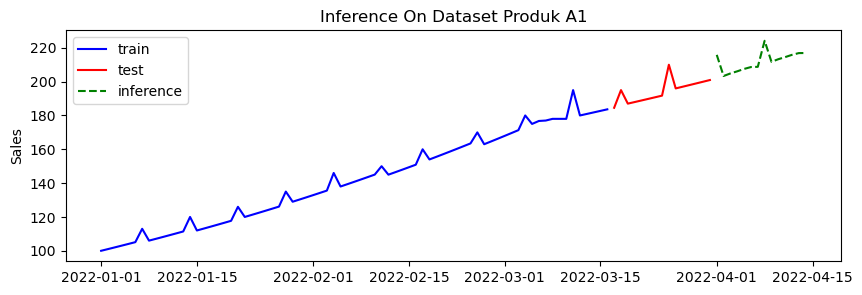

In [71]:
# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(a1_X_train, 'b-', label='train')        # plot data train
plt.plot(a1_X_test, 'r-', label='test')          # plot data test
plt.plot(inf_a1, 'g--', label='inference')       # plot inference
plt.title('Inference On Dataset Produk A1')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Produk A2

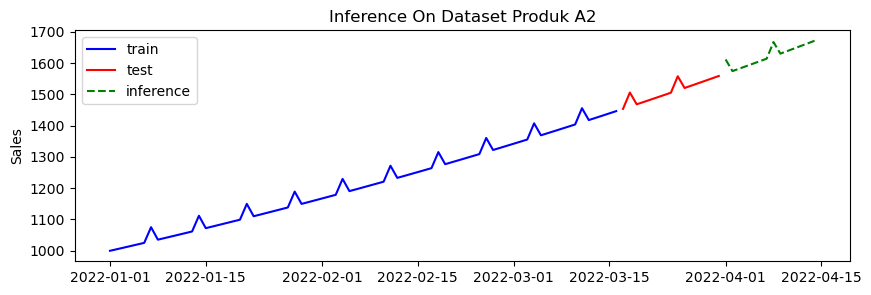

In [72]:
# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(a2_X_train, 'b-', label='train')        # plot data train
plt.plot(a2_X_test, 'r-', label='test')          # plot data test
plt.plot(inf_a2, 'g--', label='inference')       # plot inference
plt.title('Inference On Dataset Produk A2')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Produk B1

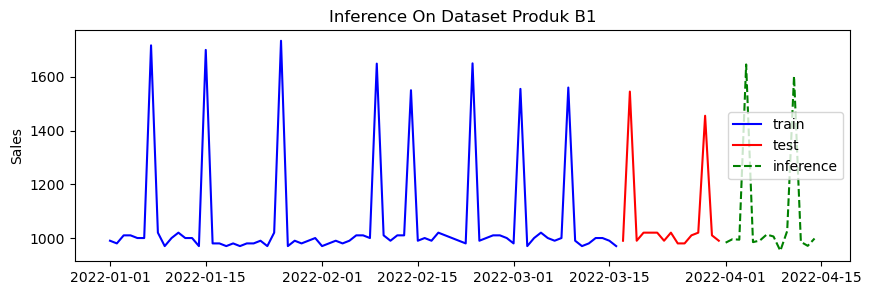

In [73]:
# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(b1_X_train, 'b-', label='train')        # plot data train
plt.plot(b1_X_test, 'r-', label='test')          # plot data test
plt.plot(inf_b1, 'g--', label='inference')       # plot inference
plt.title('Inference On Dataset Produk B1')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Produk B2

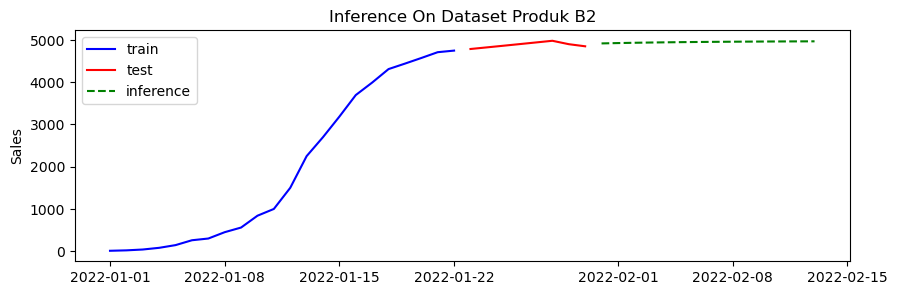

In [74]:
# membuat figure 12 x 4
plt.figure(figsize=[10,3])
plt.plot(b2_X_train, 'b-', label='train')        # plot data train
plt.plot(b2_X_test, 'r-', label='test')          # plot data test
plt.plot(inf_b2, 'g--', label='inference')       # plot inference
plt.title('Inference On Dataset Produk B2')
plt.ylabel('Sales')
plt.legend()
plt.show()

# 5 - Conclusion / Overall Analysis
## Model Analysis
### Exponential Smoothing Holt's Winter

Beberapa analisa dari model Holt's Winter :
- Performa model cukup baik pada Produk A1 dan A2
- Namun buruk pada Produk B1 dan B2

Kelebihan dan Kelemahan model Holt's Winter adalah:
- Kelebihan :
    - Akurasi cukup baik dengan rata - rata persentase eror kecil pada dataset yang memiliki trend dan season
    - Model mampu mengikuti pola data dengan baik
- Kekurangan
    - Kurang baik dalam memprediksi seasonalitas (spike) yang dipengaruhi oleh faktor seperti event

### Auto Arima
Porduk A1
- Performa model cukup baik dengan hasil evaluasi berikut ini :
    - Mean Absolute Eror (MAE) : 1.0460
    - Mean Absolute Percentage Error (MAPE) : 0.5393%
    - R2 Score : 0.9598
Porduk A2
- Performa model cukup baik dengan hasil evaluasi berikut ini :
    - Mean Absolute Eror (MAE) : 2.6139
    - Mean Absolute Percentage Error (MAPE) : 0.007%
    - R2 Score : 1.00
Porduk B1
- Performa model cukup baik dengan hasil evaluasi berikut ini :
    - Mean Absolute Eror (MAE) : 26.0703
    - Mean Absolute Percentage Error (MAPE) : 2.2152%
    - R2 Score : 0.9522
Porduk B2
- Performa model cukup baik dengan hasil evaluasi berikut ini :
    - Mean Absolute Eror (MAE) : 41.31
    - Mean Absolute Percentage Error (MAPE) : 0.8408%
    - R2 Score : 0.2302

Kelebihan dan Kelemahan model Auto Arima adalah:
- Kelebihan :
    - Akurasi cukup baik dengan rata - rata persentase eror kecil
    - Mampu memprediksi seasonalitas dengan baik dan lebih baik dari model holts winter
    - Model mampu mengikuti pola data dengan baik
- Kekurangan
    -  Prediksi harus dimulai dari 1 hari setelah data train. Apabila lebih ada jeda baik maju atau mundur maka performa model akan menurun.

### Final Model
Dari hasil evaluasi maka model yang terbaik dan digunakan dalam forcasting 14 hari mendatang adalah model auto Arima

### Further Improvement
- Mencoba lebih banyak kombinasi parameters pada model holt's winter dan auto arima
- Mempersipakan lebih banyak data untuk training
- Menggunakan metode transfer learning

## Overall Analysis
### Secara keseluruhan proses yang dilakukan pada project ini adalah:
- Import semua library yang di butuhkan
- Load dataset dan eksplorasi basic info dari data
- Exploarsi Data Analytics untuk menemukan insight. 
    - Mengubah kolom day yang masih integer menjadi bentuk tanggal
    - Melakukan pengecekan pada isi setiap kolom
    - Cek missing value
    - Melakukan deskriptif analisis
    - Memecah dataset untuk mencari trend dan seasonalitas dengan Series Decompostion
- Data preprocessing dimana pada tahap ini melakukan beberapa hal seperti :
    - Cek apakah dataset statsioner atau tidak
    - Split dataset menjadi data train dan dataset
- Model Defenition and Training
- Evaluasi model dengan menggunakan visualisasi, metrik evaluasi, dan perbandingan side to side.
- Model Compartion
    - Menggunakan model Auto Arima
    - Model definition, training and evaluasi
- Perbandingan dan pemilihan antara model Holt's Winter dan Auto Arima
- Model Saving
- Forecasting 14 hari mendatang dengan best model yaitu auto arima
- Pengambilan kesimpulan
    - Analisis model
    - Kelebihan dan kekurangan model
    - Futher Improvement